In [32]:
%matplotlib inline
import numpy as np
import pprint
import operator
import math
import copy
import matplotlib.pyplot as plt

In [2]:
import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
def print_results(results):
    dumped = json.dumps(results, cls=NumpyEncoder)
    pprint.pprint(json.loads(dumped), width=50)

In [3]:
input_files = [
    '../puzzles/puzzle0.txt',
    '../puzzles/puzzle1.txt',
    '../puzzles/puzzle2.txt',
    '../puzzles/puzzle3.txt',
    '../puzzles/puzzle4.txt',
    '../puzzles/puzzle5.txt',
    '../puzzles/puzzle6.txt',
]

configurations = []
for index, f in enumerate(input_files):
    configuration = {}
    with open(f, 'r') as file:
        lines = file.readlines()
        lines = [line.strip() for line in lines]
        
        first_line = lines.pop(0)
        row, col = first_line.split(' ')        
        
        row, col = int(row), int(col)
        initial_map = np.empty((row, col))
        initial_map[:] = np.nan
        for i, line in enumerate(lines):
            temp = line.split(' ')
            for j, element in enumerate(temp):
                if element =='1':
                    initial_map[(i, j)] = 1
                elif element == '0':
                    initial_map[(i, j)] = 0
                else:
                    pass
        configuration['map'] = initial_map
    configurations.append(configuration)
        
pprint.pprint(configurations)

[{'map': array([[ 1.,  0., nan, nan],
       [ 0., nan, nan,  1.],
       [nan,  0., nan,  1.],
       [nan,  1.,  1., nan]])},
 {'map': array([[ 1., nan, nan, nan, nan, nan],
       [nan,  0.,  1.,  0., nan, nan],
       [nan, nan, nan,  0., nan,  0.],
       [nan,  0., nan, nan, nan, nan],
       [nan,  1.,  0., nan, nan, nan],
       [ 0., nan,  0., nan,  1., nan]])},
 {'map': array([[nan, nan,  1., nan, nan,  1.],
       [nan, nan, nan,  1.,  1.,  0.],
       [nan, nan,  0., nan,  0., nan],
       [ 0., nan, nan, nan,  0., nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan,  1.]])},
 {'map': array([[nan, nan, nan,  0.,  0., nan, nan, nan],
       [ 0., nan,  1.,  0., nan,  0., nan,  1.],
       [nan,  1.,  0.,  1., nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan, nan, nan],
       [nan, nan, nan,  1., nan,  0., nan,  0.],
       [ 1., nan, nan,  0., nan, nan,  1., nan],
       [nan, nan,  0., nan,  0.,  1., nan, nan],
       [nan,  0., nan, nan, 

In [4]:
# from typing import Generic, TypeVar, Dict, List, Optional, Tuple
# from abc import ABC, abstractmethod

# V = TypeVar('V') # variable type
# D = TypeVar('D') # domain type

# # Base class for all constraints
# class Constraint(Generic[V, D], ABC):
#     # The variables that the constraint is between
#     def __init__(self, variables: List[V]) -> None:
#         self.variables = variables

#     # Must be overridden by subclasses
#     @abstractmethod
#     def satisfied(self, assignment: Dict[V, D]) -> bool:
#         ...


# # A constraint satisfaction problem consists of variables of type V
# # that have ranges of values known as domains of type D and constraints
# # that determine whether a particular variable's domain selection is valid
# class CSP(Generic[V, D]):
#     def __init__(self, variables: List[V], domains: Dict[V, List[D]]) -> None:
#         self.variables:   List[V]                         = variables # variables to be constrained
#         self.domains:     Dict[V, List[D]]                = domains   # domain of each variable
#         self.constraints: Dict[V, List[Constraint[V, D]]] = {}
            
#         for variable in self.variables:
#             self.constraints[variable] = []
#             if variable not in self.domains:
#                 raise LookupError("Every variable should have a domain assigned to it.")

#     def add_constraint(self, constraint: Constraint[V, D]) -> None:
#         for variable in constraint.variables:
#             if variable not in self.variables:
#                 raise LookupError("Variable in constraint not in CSP")
#             else:
#                 self.constraints[variable].append(constraint)

#     # Check if the value assignment is consistent by checking all constraints
#     # for the given variable against it
#     def consistent(self, variable: V, assignment: Dict[V, D]) -> bool:
#         for constraint in self.constraints[variable]:
#             if not constraint.satisfied(assignment):
#                 return False
#         return True

#     def backtracking_search(self, assignment: Dict[V, D] = {}) -> Optional[Dict[V, D]]:
#         # assignment is complete if every variable is assigned (our base case)
#         if len(assignment) == len(self.variables):
#             return assignment

#         # select variable not in A
#         unassigned: List[V] = [v for v in self.variables if v not in assignment]
#         first: V = unassigned[0]
            
#         # select a value from domain    
#         for value in self.domains[first]:
#             local_assignment = assignment.copy()
#             local_assignment[first] = value
            
#             # if we're still consistent, we recurse (continue)
#             if self.consistent(first, local_assignment):
#                 result: Optional[Dict[V, D]] = self.backtracking_search(local_assignment)
#                 # if we didn't find the result, we will end up backtracking
#                 if result is not None:
#                     return result
#         return None

In [18]:
from typing import Generic, TypeVar, Dict, List, Optional, Tuple
from abc import ABC, abstractmethod

V = TypeVar('V') # variable type
D = TypeVar('D') # domain type

class Matrix():
    def __init__(self, size:int) -> None:
        self.matrix = np.empty((size, size))
        self.matrix[:] = np.nan
        self.size = size
        
    def clear_populate(self, assignment: Dict[V, D]) -> None:
        self.matrix[:] = np.nan
        for variable in assignment:
            self.matrix[variable] = assignment[variable]
            
    def up(self, variable: V) -> V:
        if variable[0] == 0:
            return None
        else:
            new_variable = tuple(map(operator.add, variable, (-1,  0)))
            return self.matrix[new_variable]
        
    def down(self, variable: V) -> V:
        if variable[0] == self.size - 1:
            return None
        else:
            new_variable = tuple(map(operator.add, variable, (+1,  0)))
            return self.matrix[new_variable]
    
    def left(self, variable: V) -> V:
        if variable[1] == 0:
            return None
        else:
            new_variable = tuple(map(operator.add, variable, ( 0, -1)))
            return self.matrix[new_variable]
        
    def right(self, variable: V) -> V:
        if variable[1] == self.size - 1:
            return None
        else:
            new_variable = tuple(map(operator.add, variable, ( 0, +1)))
            return self.matrix[new_variable]
        
    def not_populated_adjacents(self, variable: V) -> List[V]:
        
        s = self.size - 1
        left_var  = tuple(map(operator.add, variable, ( 0, -1))) if variable[1] > 0 else None
        right_var = tuple(map(operator.add, variable, ( 0, +1))) if variable[1] < s else None
        down_var  = tuple(map(operator.add, variable, (+1,  0))) if variable[0] < s else None
        up_var    = tuple(map(operator.add, variable, (-1,  0))) if variable[0] > 0 else None
        
        result = []
        if left_var  is not None and np.isnan(self.matrix[left_var ]): result.append(left_var)
        if right_var is not None and np.isnan(self.matrix[right_var]): result.append(right_var)
        if down_var  is not None and np.isnan(self.matrix[down_var ]): result.append(down_var)
        if up_var    is not None and np.isnan(self.matrix[up_var   ]): result.append(up_var)
        
        return result
    
    def adjacents(self, variable: V) -> List[V]:
            
        s = self.size - 1
        left_var  = tuple(map(operator.add, variable, ( 0, -1))) if variable[1] > 0 else None
        right_var = tuple(map(operator.add, variable, ( 0, +1))) if variable[1] < s else None
        down_var  = tuple(map(operator.add, variable, (+1,  0))) if variable[0] < s else None
        up_var    = tuple(map(operator.add, variable, (-1,  0))) if variable[0] > 0 else None
        
        result = []
        if left_var  is not None: result.append(left_var)
        if right_var is not None: result.append(right_var)
        if down_var  is not None: result.append(down_var)
        if up_var    is not None: result.append(up_var)
        
        return result
        

# Base class for all constraints
class Constraint(Generic[V, D], ABC):
    # The variables that the constraint is between
    def __init__(self, variables: List[V]) -> None:
        self.variables = variables

    # Must be overridden by subclasses
    @abstractmethod
    def satisfied(self, assignment: Dict[V, D]) -> bool:
        ...

# A constraint satisfaction problem consists of variables of type V
# that have ranges of values known as domains of type D and constraints
# that determine whether a particular variable's domain selection is valid

class CSP(Generic[V, D]):
    def __init__(self, variables: List[V], domains: Dict[V, List[D]]) -> None:
        self.variables:    List[V]                         = variables # variables to be constrained
        self.domains:      Dict[V, List[D]]                = domains   # domain of each variable
        self.constraints:  Dict[V, List[Constraint[V, D]]] = {}
        self.problem_size: int                             = int(math.sqrt(len(variables)))
        self.matrix:       Matrix                          = Matrix(self.problem_size)
        assert math.isqrt(len(variables)) , "please provide valid size of variables"
            
        for variable in self.variables:
            self.constraints[variable] = []
            if variable not in self.domains:
                raise LookupError("Every variable should have a domain assigned to it.")

    def add_constraint(self, constraint: Constraint[V, D]) -> None:
        for variable in constraint.variables:
            if variable not in self.variables:
                raise LookupError("Variable in constraint not in CSP")
            else:
                self.constraints[variable].append(constraint)

    # Check if the value assignment is consistent by checking all constraints
    # for the given variable against it
    def consistent(self, variable: V, assignment: Dict[V, D]) -> bool:
        for constraint in self.constraints[variable]:
            if not constraint.satisfied(assignment):
                return False
        return True
    
    def forward_checking(self,
                         domains: Dict[V, List[D]],
                         assignment: Dict[V, D],
                         variable: Tuple,
                         value: int) -> Dict[V, List[D]]:
    
        self.matrix.clear_populate(assignment)
        matrix = self.matrix
        
        queue = matrix.not_populated_adjacents(variable)        
        new_domains = copy.deepcopy(domains)
        
#         print(matrix.matrix)
#         print(f'var: {variable}, queue: {queue}')
        
        for adj in queue:
            bad_values_in_domain = []
            for value in new_domains[adj]:
                assignment[adj] = value
                if not self.consistent(variable, assignment):
                    bad_values_in_domain.append(value)
                
                del assignment[adj]
                
            new_values_in_domain = [d for d in new_domains[adj] if d not in bad_values_in_domain]
            if not new_values_in_domain:
                            
#                 print('domains')
#                 print(new_domains)
#                 print('assignment')
#                 print(assignment)
#                 print('bad')
#                 print(bad_values_in_domain)
                
                return None
            
            new_domains[adj] = new_values_in_domain
            
            
#             print('domains')
#             print(new_domains)
#             print('assignment')
#             print(assignment)
            
        return new_domains
                
    # this method changes domains
    # make variable1 arc consistent with respect to variable2
    def arc_consistent(self, variable1: V, variable2: V, domains: Dict[V, List[D]], assignment: Dict[V, D]) -> bool:
        removed = False
        for var1_value in domains[variable1]:
            fake_assignment = copy.deepcopy(assignment)
            fake_assignment[variable1] = var1_value
            
            found_indefectible_value = False
            for var2_value in domains[variable2]:
                fake_assignment[variable2] = var2_value
                if self.consistent(variable2, fake_assignment):
                    found_indefectible_value = True
                    break
            
            del fake_assignment[variable2]
            if not found_indefectible_value:
                domains[variable1].remove(var1_value)
                removed = True
                    
        return removed
            
    
    # this version of AC_3 you must provide queue
    def AC_3(self, queue: List[Tuple], domains: Dict[V, List[D]], assignment: Dict[V, D]) -> bool:
        self.matrix.clear_populate(assignment)
        matrix = self.matrix
        
        while len(queue) > 0:
            pair = queue.pop(0)
            var1 = pair[0]
            var2 = pair[1]
            domain_changed = self.arc_consistent(var1, var2, domains, assignment)
            if not domain_changed:
                continue
            if len(domains[var1]) == 0:
                return False
            
            adjacents = matrix.adjacents(var1)
            adjacents.remove(var2)
            
            for adj in adjacents:
                queue.append((adj, var1))
                
        return True
            
        
    def MAC(self, domains: Dict[V, List[D]], assignment: Dict[V, D], variable: Tuple) -> bool:
        self.matrix.clear_populate(assignment)
        matrix = self.matrix
        
        new_domains = copy.deepcopy(domains)
        
        adjacents = matrix.not_populated_adjacents(variable)
        queue = []
        for adj in adjacents:
            queue.append((adj, variable))
            
        if self.AC_3(queue, new_domains, assignment):
            return new_domains
        else:
            return None
    
    def MRV(self, domain: List[D]) -> int:
        return len(domain)
    
    def MCV(self, variable: V, matrix: Matrix) -> int:
        return len(matrix.not_populated_adjacents(variable))
    
    def backtracking_search(self, assignment: Dict[V, D] = {}) -> Optional[Dict[V, D]]:
        # assignment is complete if every variable is assigned (our base case)
        if len(assignment) == len(self.variables):
            return assignment

        # select variable not in A
#         temp_matrix = Matrix(self.problem_size)
#         temp_matrix.clear_populate(assignment)
        
        unassigned: List[V] = [v for v in self.variables if v not in assignment]
        unassigned.sort(key=lambda v: (self.MRV(self.domains[v])))
        first: V = unassigned[0]
            
        # select a value from domain    
        for value in self.domains[first]:
            local_assignment = assignment.copy()
            local_assignment[first] = value
            
            # if we're still consistent, we recurse (continue)
            if self.consistent(first, local_assignment):
                result: Optional[Dict[V, D]] = self.backtracking_search(local_assignment)
                # if we didn't find the result, we will end up backtracking
                if result is not None:
                    return result
        return None
    
                    
    def backtracking_search_with_FC(self, assignment: Dict[V, D], domains: Dict[V, List[D]]) -> Optional[Dict[V, D]]:
        # assignment is complete if every variable is assigned (our base case)
        if len(assignment) == len(self.variables):
            return assignment

        # select variable not in A
        unassigned: List[V] = [v for v in self.variables if v not in assignment]
            
#         print('unassigned')
#         print(unassigned)
        
        unassigned.sort(key=lambda v: (self.MRV(domains[v])))
        
#         print('sorted unassigned')
#         print(unassigned)
        
        first: V = unassigned[0]
            
        # select a value from domain    
        for value in domains[first]:
#             print(f'selected value:{value}, from domain:{domains[first]}, for variable:{first}')
            local_assignment = assignment.copy()
            local_assignment[first] = value
            
#             print('local_assignment')
#             print(local_assignment)
            
            new_domains = self.forward_checking(domains, local_assignment, first, value)
            if not new_domains:
                continue
                
            

            result: Optional[Dict[V, D]] = self.backtracking_search_with_FC(local_assignment, new_domains)
            if result is not None:
                return result
            
        return None
    
    
    def backtracking_search_with_MAC(self, assignment: Dict[V, D], domains: Dict[V, List[D]]) -> Optional[Dict[V, D]]:
        # assignment is complete if every variable is assigned (our base case)
        if len(assignment) == len(self.variables):
            return assignment

        # select variable not in A
        unassigned: List[V] = [v for v in self.variables if v not in assignment]
            
#         print('unassigned')
#         print(unassigned)
        
        unassigned.sort(key=lambda v: (self.MRV(domains[v])))
        
#         print('sorted unassigned')
#         print(unassigned)
        
        first: V = unassigned[0]
            
        # select a value from domain    
        for value in domains[first]:
#             print(f'selected value:{value}, from domain:{domains[first]}, for variable:{first}')
            local_assignment = assignment.copy()
            local_assignment[first] = value
            
#             print('local_assignment')
#             print(local_assignment)
            
            new_domains = self.MAC(domains, local_assignment, first)
            if not new_domains:
                continue

            result: Optional[Dict[V, D]] = self.backtracking_search_with_MAC(local_assignment, new_domains)
            if result is not None:
                return result
            
        return None

In [6]:
class FirstConstraint(Constraint[Tuple, int]):
    
    def __init__(self, variables: List[Tuple], problem_size: int) -> None:
        super().__init__(variables)
        self.ps        = problem_size
        self.matrix    = Matrix(problem_size)
        
        
    def satisfied(self, assignment: Dict[Tuple, int]) -> bool:
        
        
        self.matrix.clear_populate(assignment)
        matrix = self.matrix

        for var in assignment:
            if matrix.left(var) == matrix.matrix[var] == matrix.right(var):
#                 print("first")
                return False
            
            if matrix.up(var) == matrix.matrix[var] == matrix.down(var):
#                 print("first")
                return False

        return True
    
    
class SecondConstraint(Constraint[Tuple, int]):
    
    def __init__(self, variables: List[Tuple], problem_size: int) -> None:
        super().__init__(variables)
        self.ps        = problem_size
        self.matrix    = Matrix(problem_size)

    def satisfied(self, assignment: Dict[Tuple, int]) -> bool:
        
        self.matrix.clear_populate(assignment)
        matrix = self.matrix.matrix

        for i in range(0, self.ps):
            if not np.isnan(matrix[i,:]).any():
                if np.sum(matrix[i,:]) != self.ps / 2.0:
#                     print("second")
                    return False
                
        for i in range(0, self.ps):
            if not np.isnan(matrix[:,i]).any():
                if np.sum(matrix[:,i]) != self.ps / 2.0:
#                     print("second")
                    return False
                
        return True
    

class ThirdConstraint(Constraint[Tuple, int]):
    
    def __init__(self, variables: List[Tuple], problem_size: int) -> None:
        super().__init__(variables)
        self.ps        = problem_size
        self.matrix    = Matrix(problem_size)

    def satisfied(self, assignment: Dict[Tuple, int]) -> bool:
        
        self.matrix.clear_populate(assignment)
        matrix = self.matrix.matrix
        
        for i in range(self.ps):  # generate pairs
            for j in range(i + 1, self.ps):
                if not np.isnan(matrix[i]).any() and np.isnan(matrix[j]).any():
                    if np.array_equal(matrix[i], matrix[j]):  # compare rows
#                         print("third")
                        return False
                

        for i in range(self.ps):  # generate pairs
            for j in range(i + 1, self.ps): 
                if not np.isnan(matrix[:, i]).any() and np.isnan(matrix[:, j]).any():
                    if np.array_equal(matrix[:,i], matrix[:, j]):  # compare columns
#                         print("third")
                        return False

        return True


In [7]:
for config in configurations:
    initial_map = config['map']
    size = len(initial_map)
    r = range(0, size)
    
    

    assignment = {}
    domains = {}
    for i in r:
        for j in r:
            variable = (i, j)

            if initial_map[variable] == 1:
                assignment[variable] = 1
                domains[variable] = [1]

            elif initial_map[variable] == 0:
                assignment[variable] = 0
                domains[variable] = [0]

            else:
                domains[variable] = [0, 1]

    config['domains']    = domains
    config['variables']  = domains.keys()
    config['assignment'] = assignment
    
pprint.pprint(configurations)

[{'assignment': {(0, 0): 1,
                 (0, 1): 0,
                 (1, 0): 0,
                 (1, 3): 1,
                 (2, 1): 0,
                 (2, 3): 1,
                 (3, 1): 1,
                 (3, 2): 1},
  'domains': {(0, 0): [1],
              (0, 1): [0],
              (0, 2): [0, 1],
              (0, 3): [0, 1],
              (1, 0): [0],
              (1, 1): [0, 1],
              (1, 2): [0, 1],
              (1, 3): [1],
              (2, 0): [0, 1],
              (2, 1): [0],
              (2, 2): [0, 1],
              (2, 3): [1],
              (3, 0): [0, 1],
              (3, 1): [1],
              (3, 2): [1],
              (3, 3): [0, 1]},
  'map': array([[ 1.,  0., nan, nan],
       [ 0., nan, nan,  1.],
       [nan,  0., nan,  1.],
       [nan,  1.,  1., nan]]),
  'variables': dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)])},
 {'assignment': {(0, 0): 1,
      

 {'assignment': {(0, 1): 0,
                 (1, 1): 0,
                 (1, 7): 1,
                 (1, 9): 0,
                 (2, 0): 1,
                 (2, 4): 1,
                 (2, 5): 0,
                 (3, 3): 0,
                 (3, 9): 1,
                 (4, 4): 1,
                 (5, 6): 1,
                 (5, 7): 1,
                 (6, 1): 1,
                 (6, 3): 1,
                 (6, 6): 1,
                 (7, 0): 0,
                 (7, 8): 0,
                 (8, 1): 1,
                 (8, 4): 1,
                 (8, 7): 1,
                 (8, 8): 0,
                 (9, 3): 0,
                 (9, 5): 0},
  'domains': {(0, 0): [0, 1],
              (0, 1): [0],
              (0, 2): [0, 1],
              (0, 3): [0, 1],
              (0, 4): [0, 1],
              (0, 5): [0, 1],
              (0, 6): [0, 1],
              (0, 7): [0, 1],
              (0, 8): [0, 1],
              (0, 9): [0, 1],
              (1, 0): [0, 1],
              (1, 1): [0],
 

In [8]:
# s = 10
# r = range(0, s)

# domains:   Dict[Tuple, List[int]] = {(i, j):[0, 1] for i in r for j in r}
# variables: List[Tuple]            = domains.keys()
    
# csp: CSP[Tuple, int] = CSP(variables, domains)
    
# csp.add_constraint(FirstConstraint(variables, s))
# csp.add_constraint(SecondConstraint(variables, s))
# csp.add_constraint(ThirdConstraint(variables, s))

# import time
# start = time.time()
# solution: Optional[Dict[Tuple, int]] = csp.backtracking_search_with_FC(assignment={}, domains=domains)
# end = time.time()
# if solution is None:
#     print("No solution found!")
# else:
#     print(f'time: {round(end - start, 5)}')
#     m = np.empty((10,10))
#     m[:] = np.nan

#     for v in solution:
#         m[v] = solution[v]

#     print(m)

In [9]:
results = []
for index, config in enumerate(configurations):

    result = {}
    domains:   Dict[Tuple, List[int]] = config['domains']
    variables: List[Tuple]            = config['variables']
    
    s = len(config['map'])
    csp: CSP[Tuple, int] = CSP(variables, domains)

    csp.add_constraint(FirstConstraint(variables, s))
    csp.add_constraint(SecondConstraint(variables, s))
    csp.add_constraint(ThirdConstraint(variables, s))

    import time
    start = time.time()
    solution: Optional[Dict[Tuple, int]] = csp.backtracking_search(assignment={})
    end = time.time()
    if solution is None:
        print("No solution found!")
        result['final']      = None
        result['time']       = end - start
        result['successful'] = False
    else:
        print(f'time: {round(end - start, 5)}')
        m = np.empty((s,s))
        m[:] = np.nan
        for v in solution:
            m[v] = solution[v]
            
        assert np.where(np.isnan(m) == True)[0].size == 0 , "find np.nan in result!"
        assert np.where(np.isnan(m) == True)[1].size == 0 , "find np.nan in result!"


        result['final']      = m.astype(np.int8, copy=False)
        result['time']       = end - start
        result['successful'] = True
    
    results.append(result)

time: 0.00598
time: 0.061
time: 0.068
time: 0.13
time: 74.85661
time: 73.76581
No solution found!


In [10]:
print_results(results)

[{'final': [[1, 0, 1, 0],
            [0, 1, 0, 1],
            [1, 0, 0, 1],
            [0, 1, 1, 0]],
  'successful': True,
  'time': 0.0059773921966552734},
 {'final': [[1, 0, 1, 1, 0, 0],
            [0, 0, 1, 0, 1, 1],
            [1, 1, 0, 0, 1, 0],
            [0, 0, 1, 1, 0, 1],
            [1, 1, 0, 1, 0, 0],
            [0, 1, 0, 0, 1, 1]],
  'successful': True,
  'time': 0.0610048770904541},
 {'final': [[0, 0, 1, 0, 1, 1],
            [1, 0, 0, 1, 1, 0],
            [1, 1, 0, 1, 0, 0],
            [0, 1, 1, 0, 0, 1],
            [1, 0, 0, 1, 1, 0],
            [0, 1, 1, 0, 0, 1]],
  'successful': True,
  'time': 0.06800436973571777},
 {'final': [[0, 1, 1, 0, 0, 1, 0, 1],
            [0, 0, 1, 0, 1, 0, 1, 1],
            [1, 1, 0, 1, 0, 1, 0, 0],
            [0, 1, 0, 0, 1, 1, 0, 1],
            [1, 0, 1, 1, 0, 0, 1, 0],
            [1, 0, 1, 0, 1, 0, 1, 0],
            [0, 1, 0, 1, 0, 1, 0, 1],
            [1, 0, 0, 1, 1, 0, 1, 0]],
  'successful': True,
  'time': 0.1300032

In [11]:
np.where(np.isnan(results[0]['final']) == True)[0].size

0

In [15]:
results_FC = []
history_FC = []
for index, config in enumerate(configurations):

    result = {}
    domains:    Dict[Tuple, List[int]] = config['domains']
    variables:  List[Tuple]            = config['variables']
    assignment: Dict[Tuple, int]       = config['assignment']
    
    s = len(config['map'])
    csp: CSP[Tuple, int] = CSP(variables, domains)

    csp.add_constraint(FirstConstraint(variables, s))
    csp.add_constraint(SecondConstraint(variables, s))
    csp.add_constraint(ThirdConstraint(variables, s))

    import time
    start = time.time()
    solution: Optional[Dict[Tuple, int]] = csp.backtracking_search_with_FC(assignment=assignment, domains=domains)
    end = time.time()
    if solution is None:
        print("No solution found!")
        result['final']      = None
        result['time']       = end - start
        result['successful'] = False
    else:
        print(f'time: {round(end - start, 5)}')
        m = np.empty((s,s))
        m[:] = np.nan
        for v in solution:
            m[v] = solution[v]
            
        assert np.where(np.isnan(m) == True)[0].size == 0 , "find np.nan in result!"
        assert np.where(np.isnan(m) == True)[1].size == 0 , "find np.nan in result!"

        result['final']      = m.astype(np.int8, copy=False)
        result['time']       = end - start
        result['successful'] = True
    
    results_FC.append(result)


time: 0.002
time: 0.07501
time: 0.05199
time: 0.113
time: 6.77505
time: 7.94955
No solution found!


In [16]:
print_results(results_FC)

[{'final': [[1, 0, 1, 0],
            [0, 1, 0, 1],
            [1, 0, 0, 1],
            [0, 1, 1, 0]],
  'successful': True,
  'time': 0.002000093460083008},
 {'final': [[1, 0, 1, 1, 0, 0],
            [0, 0, 1, 0, 1, 1],
            [1, 1, 0, 0, 1, 0],
            [0, 0, 1, 1, 0, 1],
            [1, 1, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 1]],
  'successful': True,
  'time': 0.07500672340393066},
 {'final': [[0, 0, 1, 0, 1, 1],
            [1, 0, 0, 1, 1, 0],
            [1, 1, 0, 1, 0, 0],
            [0, 1, 1, 0, 0, 1],
            [1, 0, 0, 1, 1, 0],
            [0, 1, 1, 0, 0, 1]],
  'successful': True,
  'time': 0.051990509033203125},
 {'final': [[0, 1, 1, 0, 0, 1, 0, 1],
            [0, 0, 1, 0, 1, 0, 1, 1],
            [1, 1, 0, 1, 0, 1, 0, 0],
            [0, 1, 0, 0, 1, 1, 0, 1],
            [1, 0, 1, 1, 0, 0, 1, 0],
            [1, 0, 1, 0, 1, 0, 1, 0],
            [0, 1, 0, 1, 0, 1, 0, 1],
            [1, 0, 0, 1, 1, 0, 1, 0]],
  'successful': True,
  'time': 0.113001

In [ ]:
jkgjkgj

In [19]:
results_MAC = []
for index, config in enumerate(configurations):

    result = {}
    domains:    Dict[Tuple, List[int]] = config['domains']
    variables:  List[Tuple]            = config['variables']
    assignment: Dict[Tuple, int]       = config['assignment']
    
    s = len(config['map'])
    csp: CSP[Tuple, int] = CSP(variables, domains)

    csp.add_constraint(FirstConstraint(variables, s))
    csp.add_constraint(SecondConstraint(variables, s))
    csp.add_constraint(ThirdConstraint(variables, s))

    import time
    start = time.time()
    solution: Optional[Dict[Tuple, int]] = csp.backtracking_search_with_MAC(assignment=assignment, domains=domains)
    end = time.time()
    if solution is None:
        print("No solution found!")
        result['final']      = None
        result['time']       = end - start
        result['successful'] = False
    else:
        print(f'time: {round(end - start, 5)}')
        m = np.empty((s,s))
        m[:] = np.nan
        for v in solution:
            m[v] = solution[v]
            
        assert np.where(np.isnan(m) == True)[0].size == 0 , "find np.nan in result!"
        assert np.where(np.isnan(m) == True)[1].size == 0 , "find np.nan in result!"

        result['final']      = m.astype(np.int8, copy=False)
        result['time']       = end - start
        result['successful'] = True
    
    results_MAC.append(result)


time: 0.01404
time: 0.11766
time: 0.12003
time: 0.37346
time: 22.14644
time: 21.32835
No solution found!


In [20]:
print_results(results_MAC)

[{'final': [[1, 0, 1, 0],
            [0, 1, 0, 1],
            [1, 0, 0, 1],
            [0, 1, 1, 0]],
  'successful': True,
  'time': 0.014036178588867188},
 {'final': [[1, 0, 1, 1, 0, 0],
            [0, 0, 1, 0, 1, 1],
            [1, 1, 0, 0, 1, 0],
            [0, 0, 1, 1, 0, 1],
            [1, 1, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 1]],
  'successful': True,
  'time': 0.11765670776367188},
 {'final': [[0, 0, 1, 0, 1, 1],
            [1, 0, 0, 1, 1, 0],
            [1, 1, 0, 1, 0, 0],
            [0, 1, 1, 0, 0, 1],
            [1, 0, 0, 1, 1, 0],
            [0, 1, 1, 0, 0, 1]],
  'successful': True,
  'time': 0.12003159523010254},
 {'final': [[0, 1, 1, 0, 0, 1, 0, 1],
            [0, 0, 1, 0, 1, 0, 1, 1],
            [1, 1, 0, 1, 0, 1, 0, 0],
            [0, 1, 0, 0, 1, 1, 0, 1],
            [1, 0, 1, 1, 0, 0, 1, 0],
            [1, 0, 1, 0, 1, 0, 1, 0],
            [0, 1, 0, 1, 0, 1, 0, 1],
            [1, 0, 0, 1, 1, 0, 1, 0]],
  'successful': True,
  'time': 0.3734612

In [ ]:
import random
v = {}
for i in [random.randrange(0,10) for m in range(0,20)]:
    for j in [random.randrange(0, 10) for m in range(0, 20)]:
        chance = random.random()
        if chance < 0.3:
            v[(i, j)] = [0]
        elif 0.3 <= chance < 0.7:
            v[(i, j)] = [1]
        else:
            v[(i, j)] = [0, 1]
        
pprint.pprint(v)
print('-----------')
v = {k: v for k, v in sorted(v.items(), key=lambda item: len(item[1]))}
pprint.pprint(v, sort_dicts=False)

counter = 0
for var, domain in v.items():
    print(f'var: {var} , domain: {domain}')
    


        
print(var)
print(domain)
    
a = np.empty((10,10))
a[:] = np.nan

# for cor in v:
#     a[cor] = v[cor]
    
# for i in range(0, 10):
#     if not np.isnan(a[i,:]).any():
#         print(np.sum(a[i,:]))
    
print('\n\n\n')  
print(a[np.isnan(a[i,:]).any(), :])
print('\n\n\n')  
print(a)
print(len(a))
print('\n\n\n')
print(a[:, 0]!=np.nan)
print('\n\n\n')
print(a[a[:,0] == np.nan, :])

In [ ]:
A=np.array([[0, 1, 0, 0, 0, 1],
            [0, 0, 0, 1, 0, 1],
            [0, 1, 0, 0, 0, 1],
            [1, 0, 1, 0, 1, 1],
            [1, 1, 1, 0, 0, 0],
            [0, 1, 0, 1, 0, 1]])

A = np.ones((10, 10))


for i in range(len(A)):  # generate pairs
    for j in range(i + 1, len(A)): 
        if np.array_equal(A[i], A[j]):  # compare rows
            print(i, j)
        else:
            pass
        
print('-------')
for i in range(len(A)):  # generate pairs
    for j in range(i + 1, len(A)): 
        if np.array_equal(A[:,i], A[:,j]):  # compare rows
            print(i, j)
        else:
            pass

In [ ]:
x = np.nan
if x == 0 and ~np.isnan(x):
    print("return")

In [ ]:
np.ones((3,3))

In [ ]:
np.nan is np.nan

In [ ]:
r = range(0, 10)
{(i, j):[1, 2] for i in r for j in r}

In [ ]:
a_list = ["bbb", "aaa", "cc", "bb"]
new_list = sorted(a_list, key=lambda x: (len(x), x))
print(new_list)

In [ ]:
A = np.empty((7,7))
B = np.ones((5,5))

A[:] = np.nan
r, c = 1, 1
A[r:r+B.shape[0], c:c+B.shape[1]] = B
A

In [ ]:
m = {
    "hello": 2,
    "bye": 0,
}

del m['hello']
m

In [ ]:
a = [1, 3, 5]
b = [1, 2, 3, 4, 5, 6]

[x for x in b if x not in a]

In [ ]:
m.astype(np.int8)

In [ ]:
math.sqrt(100)

In [ ]:
a = np.full((5,5), np.nan, dtype=None)
a[:] = np.nan
a.dtype

In [ ]:
x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
def get_length(item):
    return item[1]

{k: v for k, v in sorted(x.items(), key=lambda item: (get_length(item)))}

In [ ]:
numbers = [x for x in range(20)]

for number in numbers:
    if number % 2 == 0:
        numbers.remove(number)
        
numbers

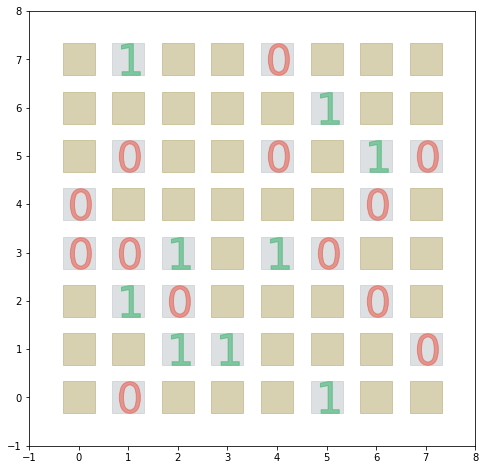

In [87]:
def draw_config(config, save=False, path=None ,file_name=None, show=True, dpi=100):
    matrix    = config['map']
    lists     = matrix.tolist()
    domains   = config['domains']
    size = len(matrix)

    fig, ax = plt.subplots(figsize=(size, size))
    kwargs = {
        's'          : 1000,
        'c'          : '#bdc3c7',
        'marker'     : "s",
        'alpha'      : 0.5,
    }

    zeros = []
    ones  = []
    nans  = []
    total = []
    
    ax.invert_yaxis()
    ax.set_xlim(-1, +1 * size)
    ax.set_ylim(-1, +1 * size)

    
    for row_idx, row in enumerate(lists):
        for col_idx, col in enumerate(row):
            cords = (row_idx, col_idx)
            if np.isnan(matrix[cords]):
                nans.append(cords)
            elif matrix[cords] == 0:
                zeros.append(cords)
            elif matrix[cords] == 1:
                ones.append(cords)
            total.append(cords)
            
    zero_only_domain = []
    one_only_domain = []
    full_domain = []
    
    for cell in nans:
        if len(domains[cell]) == 1 and 1 in domains[cell]:
            one_only_domain.append(cell)
        elif len(domains[cell]) == 1 and 0 in domains[cell]:
            zero_only_domain.append(cell)
        else:
            full_domain.append(cell)
                
    
#     ax.scatter([cord[0] for cord in total], [cord[1] for cord in total], **kwargs)

    kwargs['c'] = '#e74c3c'
    ax.scatter([cord[0] for cord in zero_only_domain], [cord[1] for cord in zero_only_domain], **kwargs)
    
    kwargs['c'] = '#27ae60'
    ax.scatter([cord[0] for cord in one_only_domain], [cord[1] for cord in one_only_domain], **kwargs)
    
    kwargs['c'] = '#b1a467'
    ax.scatter([cord[0] for cord in full_domain], [cord[1] for cord in full_domain], **kwargs)
        

    kwargs['c'] = '#bdc3c7'
    kwargs['marker'] = 's'
    ax.scatter([cord[0] for cord in ones], [cord[1] for cord in ones], **kwargs)
    kwargs['c'] = '#27ae60'
    kwargs['marker'] = '$1$'
    ax.scatter([cord[0] for cord in ones], [cord[1] for cord in ones], **kwargs)

    
    kwargs['c'] = '#bdc3c7'
    kwargs['marker'] = 's'
    ax.scatter([cord[0] for cord in zeros], [cord[1] for cord in zeros], **kwargs)
    kwargs['c'] = '#e74c3c'
    kwargs['marker'] = '$0$'
    ax.scatter([cord[0] for cord in zeros], [cord[1] for cord in zeros], **kwargs)
        


    if show:
        plt.show()
    if save:
        from pathlib import Path
        if not path:
            path = "../default_export_path/"
        Path(path).mkdir(parents=True, exist_ok=True)
        fig.savefig(f'{path}{file_name}', dpi=dpi)
        plt.close(fig)

draw_config(configurations[3])

In [83]:
configurations[3]

{'map': array([[nan, nan, nan,  0.,  0., nan, nan, nan],
        [ 0., nan,  1.,  0., nan,  0., nan,  1.],
        [nan,  1.,  0.,  1., nan, nan, nan, nan],
        [nan,  1., nan, nan, nan, nan, nan, nan],
        [nan, nan, nan,  1., nan,  0., nan,  0.],
        [ 1., nan, nan,  0., nan, nan,  1., nan],
        [nan, nan,  0., nan,  0.,  1., nan, nan],
        [nan,  0., nan, nan, nan,  0., nan, nan]]),
 'domains': {(0, 0): [0, 1],
  (0, 1): [0, 1],
  (0, 2): [0, 1],
  (0, 3): [0],
  (0, 4): [0],
  (0, 5): [0, 1],
  (0, 6): [0, 1],
  (0, 7): [0, 1],
  (1, 0): [0],
  (1, 1): [0, 1],
  (1, 2): [1],
  (1, 3): [0],
  (1, 4): [0, 1],
  (1, 5): [0],
  (1, 6): [0, 1],
  (1, 7): [1],
  (2, 0): [0, 1],
  (2, 1): [1],
  (2, 2): [0],
  (2, 3): [1],
  (2, 4): [0, 1],
  (2, 5): [0, 1],
  (2, 6): [0, 1],
  (2, 7): [0, 1],
  (3, 0): [0, 1],
  (3, 1): [1],
  (3, 2): [0, 1],
  (3, 3): [0, 1],
  (3, 4): [0, 1],
  (3, 5): [0, 1],
  (3, 6): [0, 1],
  (3, 7): [0, 1],
  (4, 0): [0, 1],
  (4, 1): [0, 1],
 

No variables match your requested type.
